<a href="https://colab.research.google.com/github/Raizel820/Basic-Text-Classification-with-Naive-Bayes/blob/master/Mini_Project_Naive_Bayes_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Text Classification with Naive Bayes
***
In the mini-project, I'll demonstrate the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. I'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [6]:
import pandas as pd
url ='https://raw.githubusercontent.com/Raizel820/Basic-Text-Classification-with-Naive-Bayes/master/critics.csv'
critics = pd.read_csv(url)
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.sample(10)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
14839,Jeff Millar,fresh,119099,Houston Chronicle,If you have an interest in capital-letter Good...,2000-01-01,13474,Fallen
26117,Adam Graham,rotten,450314,Detroit News,"This is purely gutter, fanboy, Cheez Whiz cine...",2008-12-05,770676216,Punisher: War Zone
16368,Mordaunt Hall,fresh,20629,New York Times,"Messrs. Milestone, Abbott and Anderson in this...",2003-05-20,17121,All Quiet on the Western Front
20730,Peter Stack,fresh,156901,San Francisco Chronicle,Veracity is undermined by the very idea that t...,2001-04-03,196036617,Sib
24980,Jeff Millar,rotten,120596,Houston Chronicle,"Steve Cohen's screenplay, is pretty much DOA.",2000-01-01,12070,The Bachelor
12039,James Berardinelli,fresh,118548,ReelViews,A fairly routine thriller that gets high marks...,2000-01-01,13603,Absolute Power
4867,Sean O'Connell,fresh,107290,Washington Post,"""Jurassic Park"" was impressive in 1993. Twenty...",2013-04-04,10983,Jurassic Park
14111,Roger Ebert,fresh,118749,Chicago Sun-Times,"As a writer and director, Paul Thomas Anderson...",2000-01-01,14134,Boogie Nights
27543,J. Hoberman,fresh,165798,Village Voice,Ghost Dog is an impeccably shot and sensationa...,2000-01-01,13267,Ghost Dog: The Way of the Samurai
20988,Gene Seymour,fresh,142192,Newsday,"James Foley directs with lean, mean stylishnes...",2000-01-01,14666,The Corruptor


### Explore

In [7]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


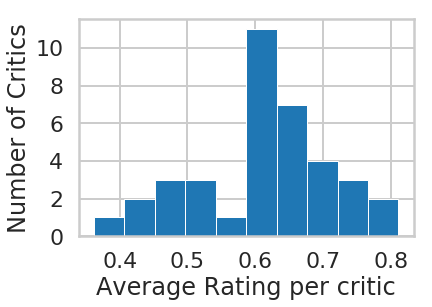

In [8]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<b>Question 1:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

<b>Answer:</b>

It's a positively skewed graph. We can tell that people are tend to rate critics slightly above the middle score (0.5). On the other hand, we have very limited number of observations here. Therefore, we may have sampling bias, and our generalization may not be accurate.

## The Vector Space Model and a Search Engine

### In Code

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [0]:
def make_xy(critics, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

<p><b>Question set - II:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print "MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

MN Accuracy: 75.71%


In [21]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.92
Accuracy on test data:     0.76


By looking at training data, we can see that there is an overfit issue on training data because if our model does much better on the training set than on the test set, then we’re likely overfitting (92% vs 77%). Therefore, it's not a good classifier. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Question Set 3</h3>

<p><b>Question:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear 5 or fewer documents.</p>

<p><b>Question:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

Answer:

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [0]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [0]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [0]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [0]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [61]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 5.000000
min_df: 0.001000


In [62]:
print("alpha: {}".format(best_alpha))

alpha: 5


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [63]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.794389
Accuracy on test data:     0.716030


Compared to previous results, these results are less accurate but we overcome **overfitting** issue.

In [64]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2061 2195]
 [ 898 5738]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

I will
* firstly create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [65]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
('        entertaining', '0.87')
('               witty', '0.85')
('              moving', '0.84')
('             perfect', '0.84')
('           enjoyable', '0.84')
('            powerful', '0.83')
('         intelligent', '0.83')
('               years', '0.83')
('       entertainment', '0.83')
('               great', '0.82')
Bad words	     P(fresh | word)
('               video', '0.31')
('                flat', '0.30')
('                lame', '0.28')
('                dull', '0.28')
('               worst', '0.27')
('       unfortunately', '0.27')
('             problem', '0.27')
('               bland', '0.26')
('             unfunny', '0.25')
('               fails', '0.24')


We can see mis-predictions as well.

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [66]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and 

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>I will :</b>
<ul>
<li> use the best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> discuss whether this is an expected result or not
</ul>
</div>
</div>

In [67]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[0.08483136, 0.91516864]])

### TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.**


In [0]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [114]:
Xtfidf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [115]:
Xtfidf.shape

(15561, 22125)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment </h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [0]:
import gensim

In [0]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X=vectorizer.fit_transform(critics.quote)

In [0]:
corpus=vectorizer.get_feature_names()
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [0]:
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=5, update_every=1, chunksize=1000, passes=1)

In [126]:
lda.print_topics()

[(0,
  u'0.017*"movie" + 0.009*"funny" + 0.008*"film" + 0.006*"like" + 0.004*"thriller" + 0.004*"horror" + 0.004*"picture" + 0.003*"stuff" + 0.003*"just" + 0.003*"isn"'),
 (1,
  u'0.018*"film" + 0.008*"movie" + 0.006*"story" + 0.006*"self" + 0.005*"performance" + 0.005*"character" + 0.004*"new" + 0.004*"time" + 0.004*"world" + 0.004*"war"'),
 (2,
  u'0.019*"movie" + 0.012*"film" + 0.006*"comedy" + 0.006*"like" + 0.005*"good" + 0.005*"story" + 0.004*"big" + 0.004*"movies" + 0.004*"time" + 0.004*"make"'),
 (3,
  u'0.012*"movie" + 0.006*"like" + 0.006*"film" + 0.006*"good" + 0.005*"comedy" + 0.005*"really" + 0.004*"doesn" + 0.004*"time" + 0.004*"way" + 0.004*"ve"'),
 (4,
  u'0.019*"film" + 0.008*"movie" + 0.007*"best" + 0.005*"director" + 0.005*"work" + 0.004*"fun" + 0.004*"action" + 0.004*"characters" + 0.003*"just" + 0.003*"direction"')]

We can see how each document fits in with the topics.